In [1]:
import os
import sys

cwd = os.getcwd()
pwd = cwd[:cwd.rfind('/')]
sys.path.append(pwd)

import numpy as np
import sklearn.metrics
from sankey import sankey
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms

from model import *
from logger import Logger, ModelLogger
from dataloader import DatasetClean, DatasetVal

/home/liao0090/miniconda3/envs/cvtorch/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
issave = True

In [16]:
# Dataset
data_path = '../data/'
cln_dataset = DatasetClean(data_path)
labs = ['bckgrnd', 'person', 'bike', 'car', 'drone', 'boat', 'animal', 'obstacle', 'cnstn', 'plant', 'road', 'sky']
labbak = ['person', 'bike', 'car', 'drone', 'boat', 'animal', 'obstacle', 'cnstn', 'plant', 'road', 'sky', 'bckgrnd']
cmap = np.array([
        (  0,   0,   0),  #  Background
        (192, 128, 128),  #  Person
        (  0, 128,   0),  #  Bike
        (128, 128, 128),  #  Car
        (128,   0,   0),  #  Drone
        (  0,   0, 128),  #  Boat
        (192,   0, 128),  #  Animal
        (192,   0,   0),  #  Obstacle
        (192, 128,   0),  #  Construction
        (  0,  64,   0),  #  plant
        (128, 128,   0),  #  Road
        (  0, 128, 128)   #  Sky
    ])
cdict = {labs[i]: np.append(cmap[i] / 255, 1.) for i in range(12)}
cdict['bckgrnd'] = np.array((128/255, 128/255, 128/255, 1.))

In [4]:
mname = 'deeplabv3'
lname = 'focalloss'
flag = '1114'
flag_run = "{}_{}".format(lname, flag)
logger = Logger(save_path='../saved_models/', prj_name=mname, flag_run=flag_run)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def restore_model(mname, logger):
    assert logger.path_existed, f"Path {logger.dir_save} not found"
    model_logger = ModelLogger(logger, state_only=True)
    model_logger.metric_name = 'iou'

    # ===== Model =====
    model = get_model(mname)
    model = model_logger.load_model('best', model=model).to(device)
    model.eval()
    return model

In [5]:
# load dataset and model
val_dataset = DatasetVal('../data/')
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=1)
cln_dataloader = torch.utils.data.DataLoader(cln_dataset, batch_size=2, shuffle=False, num_workers=1)
model = restore_model(mname, logger)

## Confusion

### Few images

In [8]:
# get image
idx = [222, 333, 444, 555]
xs, ys, y0s = [], [], []
for i in idx:
    x, y = val_dataset[i]
    _, y0 = cln_dataset[i]
    xs.append(x)
    ys.append(y)
    y0s.append(torch.Tensor(y0))
xs = torch.stack(xs)
ys = torch.stack(ys)
y0s = torch.stack(y0s)

# get prediction
with torch.no_grad():
    pred_mask = model(xs.to(device))
pred_mask = torch.softmax(pred_mask, dim=1)
pred = torch.argmax(pred_mask, dim=1)
pred = pred.cpu()
# transfer to label map
h, w = pred.shape[1:]
pred = transforms.functional.crop(pred, 8, 0, h-16, w)

### Full dataset

In [6]:
cfms = np.load(logger.path_join('conf_mat.npy'))

In [12]:
cfms = np.zeros((12, 12), dtype=np.float64)

for batch_i, (xy_val, xy_cln) in enumerate(zip(val_dataloader, cln_dataloader)):
    # get prediction
    with torch.no_grad():
        xs, _ = xy_val
        pred_mask = model(xs.to(device))
    pred_mask = torch.softmax(pred_mask, dim=1)
    y_pred = torch.argmax(pred_mask, dim=1)
    y_pred = y_pred.cpu()
    # transfer to label map
    h, w = y_pred.shape[1:]
    y_pred = transforms.functional.crop(y_pred, 8, 0, h-16, w)
    # get true label
    _, y_true = xy_cln

    y_pred = y_pred.reshape(-1).numpy()
    y_true = y_true.reshape(-1).numpy()
    cfm = sklearn.metrics.confusion_matrix(y_true, y_pred, labels=range(12))
    cfms += cfm

np.save(logger.path_join('conf_mat.npy'), cfms)

(12, 12)

In [12]:
def plot_confmat(cfm_rn):
    fig, ax = plt.subplots(figsize=(8, 5))

    img = plt.imshow(cfm_rn, interpolation='nearest', 
                    cmap=plt.cm.Blues, vmin=0.0, vmax=1.0)
    # set labels
    n_cls = cfm_rn.shape[0]
    fig.colorbar(img, ax=ax, fraction=0.046, pad=0.04)
    labs = ['bckgrnd', 'person', 'bike', 'car', 'drone', 'boat', 'animal', 'obstacle', 'cnstn', 'plant', 'road', 'sky']
    ax.set(yticks=np.arange(n_cls), yticklabels=labs,
            ylabel='True Label', xlabel='Predicted Label')
    ax.set_xticks(np.arange(n_cls), labs, rotation='vertical')

    fig.tight_layout()
    plt.show()
    return fig

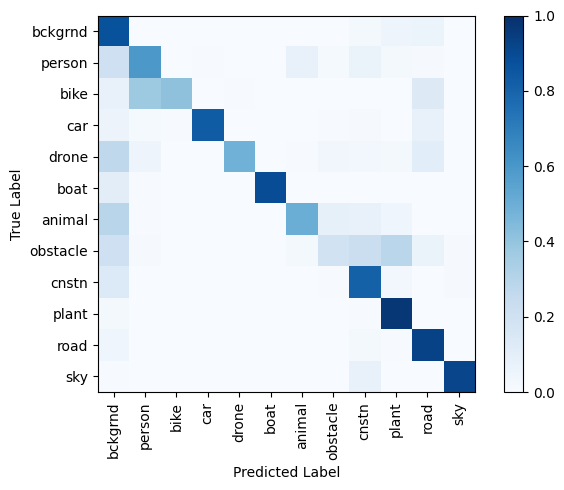

In [13]:
cfm_rn = cfms / cfms.sum(axis=1, keepdims=True)
fig = plot_confmat(cfm_rn)

## Sankey

In [17]:
row, col = [], []
cfm_err = np.zeros(12*11)
for r in range(12):
    for c in range(12):
        if r != c:
            row.append(labs[r])
            col.append(labs[c])
            cfm_err[r*11+c] = cfms[r, c]

fig = sankey(left=row, right=col, leftWeight=cfm_err, colorDict=cdict,
             leftLabels=list(reversed(labbak)), rightLabels=list(reversed(labbak)), fontsize=8)
if issave:
    fig.savefig(logger.path_join('sankey.pdf'), bbox_inches='tight')
fig

<Figure size 800x500 with 1 Axes>